<a href="https://colab.research.google.com/github/daisein/Coursera-Data-Science-with-Python-UMichigan/blob/master/TF2C1W5CapstoneProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Inspect and preprocess the dataset**
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [1]:
import tensorflow as tf
from scipy.io import loadmat

import random
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection 
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
# Run this cell to load the dataset

train = loadmat('drive/MyDrive/Colab Notebooks/data/train_32x32.mat')
test = loadmat('drive/MyDrive/Colab Notebooks/data/test_32x32.mat')

In [3]:
train_data = train['X']
train_targets = train['y']
print(train_data.shape)
print(train_targets.shape)

test_data = test['X']
test_targets = test['y']
print(test_data.shape)
print(test_targets.shape)

(32, 32, 3, 73257)
(73257, 1)
(32, 32, 3, 26032)
(26032, 1)


In [4]:
X_train = np.moveaxis(train_data, -1, 0)
X_test = np.moveaxis(test_data, -1, 0)
print(X_train.shape)
print(X_test.shape)

y_train = np.where(train_targets==10, 0, train_targets)
y_test =  np.where(test_targets==10, 0, test_targets)
print(y_train.shape)
print(y_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
(73257, 1)
(26032, 1)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


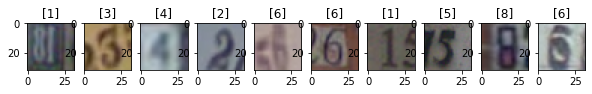

In [5]:
rand_idx = random.sample(range(0,X_train.shape[0]), 10)
fig, ax =plt.subplots(1,10,figsize=(10, 1))

for i in range(10):
    img = X_train[rand_idx[i]]
    ax[i].imshow(img)
    ax[i].set_title(y_train[rand_idx[i]])
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


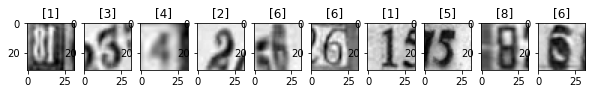

In [6]:
X_train_greyscale = np.mean(X_train, -1, keepdims=True)
X_test_greyscale = np.mean(X_test, -1, keepdims=True)

fig, ax =plt.subplots(1,10,figsize=(10, 1))

for i in range(10):
    img = X_train_greyscale[rand_idx[i],:,:,0]
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(y_train[rand_idx[i]])
plt.show()

**2. MLP neural network classifier**
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [7]:
mlp_model = Sequential([
        Flatten(input_shape=X_train[0].shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

In [8]:
mlp_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(x=X_test, y=y_test, verbose=0)

In [10]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [11]:
mlp_checkpoint_every_epoch = ModelCheckpoint(filepath = 'checkpoints_every_epoch/checkpoint_{epoch:02d}', frequency='epoch', save_weights_only=True, verbose=1)

mlp_checkpoint_best_only = ModelCheckpoint(filepath= 'checkpoints_best_only/checkpoint', save_weights_only=True, 
                                  save_freq='epoch', monitor='val_accuracy', save_best_only=True, verbose=1)

mlp_early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [12]:
mlp_callbacks = [mlp_checkpoint_every_epoch, mlp_checkpoint_best_only, mlp_early_stopping]

In [13]:
history = mlp_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=mlp_callbacks)

Epoch 1/30
1145/1145 [==============================] - 5s 4ms/step - loss: 17.6742 - accuracy: 0.1559 - val_loss: 2.4942 - val_accuracy: 0.1832

Epoch 00001: saving model to checkpoints_every_epoch/checkpoint_01

Epoch 00001: val_accuracy improved from -inf to 0.18320, saving model to checkpoints_best_only/checkpoint
Epoch 2/30
1145/1145 [==============================] - 4s 3ms/step - loss: 2.0309 - accuracy: 0.3367 - val_loss: 1.7999 - val_accuracy: 0.4163

Epoch 00002: saving model to checkpoints_every_epoch/checkpoint_02

Epoch 00002: val_accuracy improved from 0.18320 to 0.41633, saving model to checkpoints_best_only/checkpoint
Epoch 3/30
1145/1145 [==============================] - 4s 3ms/step - loss: 1.5390 - accuracy: 0.5123 - val_loss: 1.4246 - val_accuracy: 0.5822

Epoch 00003: saving model to checkpoints_every_epoch/checkpoint_03

Epoch 00003: val_accuracy improved from 0.41633 to 0.58221, saving model to checkpoints_best_only/checkpoint
Epoch 4/30
1145/1145 [==============

In [14]:
df = pd.DataFrame(history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy
0,17.674150,0.155930,2.494197,0.183198
1,2.030918,0.336691,1.799921,0.416334
2,1.539032,0.512347,1.424580,0.582206
3,1.401159,0.565666,1.631426,0.536378
4,1.355473,0.581473,1.420677,0.585587


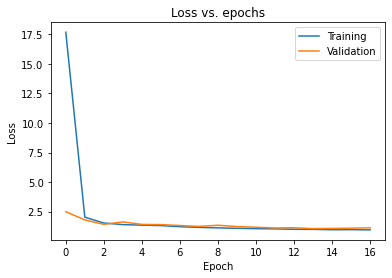

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

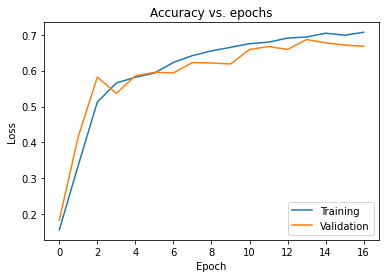

In [16]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

**3. CNN neural network classifier**

Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output.
You should design and build the model yourself. Feel free to experiment with different CNN architectures. Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)
The CNN model should use fewer trainable parameters than your MLP model.
Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
You should aim to beat the MLP model performance with fewer parameters!
Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
Compute and display the loss and accuracy of the trained model on the test set.

In [17]:
cnn_model = Sequential([
    Conv2D(filters=16, input_shape=X_train[0].shape, kernel_size=(3, 3), 
           activation='relu', padding='SAME', name='conv_1'),
    Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='SAME', name='conv_2'),
    MaxPooling2D(pool_size=(8, 8), name='pool_1'),
    Flatten(name='flatten'),
    BatchNormalization(),
    Dense(units=32, activation='relu', name='dense_1'),
    Dropout(0.2),
    Dense(units=10, activation='softmax', name='dense_2')
])

In [18]:
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x=X_test, y=y_test, verbose=0)

In [20]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 4, 4, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)               

In [21]:
cnn_checkpoint_every_epoch = ModelCheckpoint(filepath = 'cnn_checkpoints_every_epoch/checkpoint_{epoch:02d}', frequency='epoch', save_weights_only=True, verbose=1)

cnn_checkpoint_best_only = ModelCheckpoint(filepath= 'cnn_checkpoints_best_only/checkpoint', save_weights_only=True, 
                                  save_freq='epoch', monitor='val_accuracy', save_best_only=True, verbose=1)

cnn_early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [22]:
callbacks = [cnn_checkpoint_every_epoch, cnn_checkpoint_best_only, cnn_early_stopping]

In [23]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/30
2290/2290 [==============================] - 11s 4ms/step - loss: 1.4766 - accuracy: 0.4998 - val_loss: 0.8780 - val_accuracy: 0.7315

Epoch 00001: saving model to cnn_checkpoints_every_epoch/checkpoint_01

Epoch 00001: val_accuracy improved from -inf to 0.73152, saving model to cnn_checkpoints_best_only/checkpoint
Epoch 2/30
2290/2290 [==============================] - 10s 4ms/step - loss: 0.9222 - accuracy: 0.7019 - val_loss: 0.7515 - val_accuracy: 0.7767

Epoch 00002: saving model to cnn_checkpoints_every_epoch/checkpoint_02

Epoch 00002: val_accuracy improved from 0.73152 to 0.77674, saving model to cnn_checkpoints_best_only/checkpoint
Epoch 3/30
2290/2290 [==============================] - 10s 4ms/step - loss: 0.8250 - accuracy: 0.7369 - val_loss: 0.6870 - val_accuracy: 0.7992

Epoch 00003: saving model to cnn_checkpoints_every_epoch/checkpoint_03

Epoch 00003: val_accuracy improved from 0.77674 to 0.79917, saving model to cnn_checkpoints_best_only/checkpoint
Epoch 4/30

In [24]:
df = pd.DataFrame(cnn_history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.476571,0.499802,0.878009,0.731523
1,0.922196,0.701899,0.751522,0.776736
2,0.825020,0.736912,0.686980,0.799170
3,0.775396,0.754972,0.650053,0.805278
4,0.742347,0.765729,0.634011,0.813729


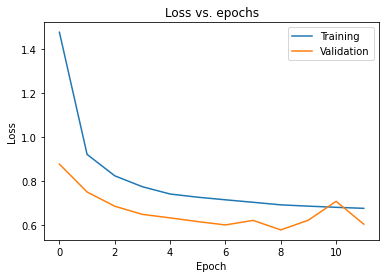

In [25]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

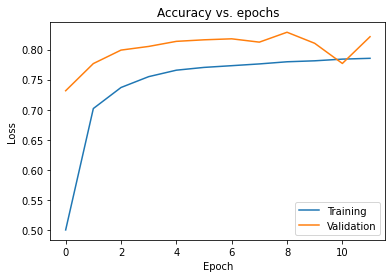

In [26]:
try:
    plt.plot(cnn_history.history['accuracy'])
    plt.plot(cnn_history.history['val_accuracy'])
except KeyError:
    plt.plot(cnn_history.history['acc'])
    plt.plot(cnn_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

**4. Get model predictions**
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [27]:
# MLP model load and prediction
mlp_model.load_weights('checkpoints_best_only/checkpoint')

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

get_test_accuracy(mlp_model, X_test, y_test)

accuracy: 0.687


In [28]:
num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = mlp_model.predict(random_test_images)

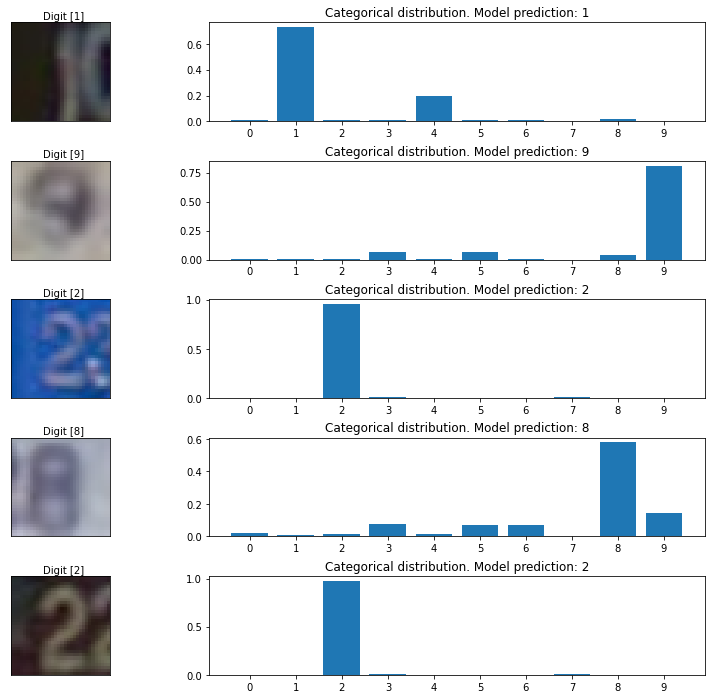

In [29]:
fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()

In [30]:
# CNN model load and prediction
cnn_model.load_weights('cnn_checkpoints_best_only/checkpoint')

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

get_test_accuracy(cnn_model, X_test, y_test)

accuracy: 0.829


In [31]:
predictions = cnn_model.predict(random_test_images)

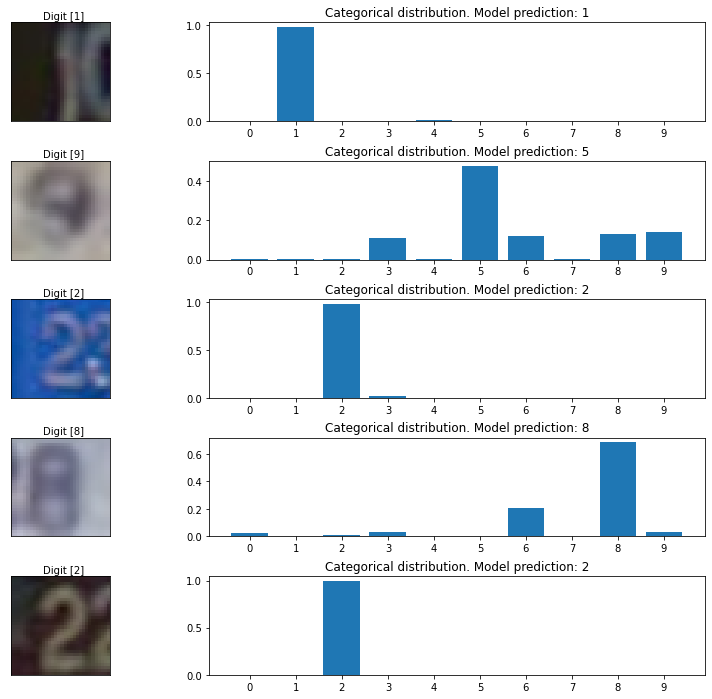

In [32]:
fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()